# scRNA-seq Analysis of *Parhyale hawaiensis* with Scanpy

Author: Miquel Sendra  
This notebook follows best practices for reproducible single-cell RNA-seq analysis using `scanpy`, starting from STARsolo outputs.

In [1]:
# Imports and settings
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Set up paths
DATA_DIR = Path("../../../workspace/scParhyale_data/raw")
PROC_DATA_DIR = Path("../../../workspace/scParhyale_data/processed")
METADATA_FILE = Path("../../../workspace/scParhyale_data/metadata.xlsx")
LIBRARIES = ["lib01", "lib02", "lib03", "lib04", "lib05", "lib06"]

## Load Metadata

In [2]:
# Load only relevant columns
metadata_df = pd.read_excel(METADATA_FILE, usecols=["Count", "Sample Name"])

# Exctract Stage and Phenotype from 'Sample Name'
metadata_df["Stage"] = metadata_df["Sample Name"].str.extract(r"\((?:Wild-type|Ablated) (\w+)\)")[0]
metadata_df["Phenotype"] = metadata_df["Sample Name"].str.extract(r"\((Wild-type|Ablated)")[0]

# Replace 'Wild-type' with 'WT' for consistency
metadata_df["Phenotype"] = metadata_df["Phenotype"].replace({"Wild-type": "WT"})


# Parse the 'Sample Name' to extract 'Library ID'
metadata_df["Library ID"] = metadata_df["Count"].apply(lambda x: f"lib0{x}")

metadata_df.index = metadata_df["Library ID"]
metadata_df.index = metadata_df.index.astype(str)
metadata_df

,Count,Sample Name,Stage,Phenotype,Library ID
Library ID,,,,,
lib01,1,Library 1 (Wild-type Early),Early,WT,lib01
lib02,2,Library 2 (Ablated Early),Early,Ablated,lib02
lib03,3,Library 3 (Wild-type Mid),Mid,WT,lib03
lib04,4,Library 4 (Ablated Mid),Mid,Ablated,lib04
lib05,5,Library 5 (Wild-type Late),Late,WT,lib05
lib06,6,Library 6 (Ablated Late),Late,Ablated,lib06


## Load STARsolo matrices and build combined AnnData object

In [5]:
# Load libraries and store AnnData objects
adatas = []
for lib in LIBRARIES:
    ad = sc.read_10x_mtx(DATA_DIR / lib, var_names='gene_symbols', cache=True)
    ad.obs["library_id"] = lib
    ad.obs = ad.obs.merge(metadata_df, left_on="library_id", right_index=True)
    ad.var_names_make_unique()
    adatas.append(ad)

# Concatenate all
adata = anndata.concat(
    adatas,
    label="batch",
    keys=LIBRARIES,
    index_unique="-"
)

adata

AnnData object with n_obs × n_vars = 20172 × 54715
    obs: 'library_id', 'Count', 'Sample Name', 'Stage', 'Phenotype', 'Library ID', 'batch'

## Count Matrix uality control
First Quality control (read quality control) was done at Janelia and it is in the folder sent by Tassos.

Count matrix quality control (QC) metrics and visualization for the integrated single-cell dataset using `Scanpy` and other best practices from the [sc-best-practices.org](https://www.sc-best-practices.org/) guidelines

1. Basic QC summary

In [9]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

print(f"Total cells: {adata.n_obs:,}")
print(f"Total genes: {adata.n_vars:,}")

adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, 'A1') else adata.X.sum(axis=1)
adata.obs['log_counts'] = np.log1p(adata.obs['n_counts'])
adata.obs['log_genes'] = np.log1p(adata.obs['n_genes_by_counts'])

Total cells: 20,172
Total genes: 54,715


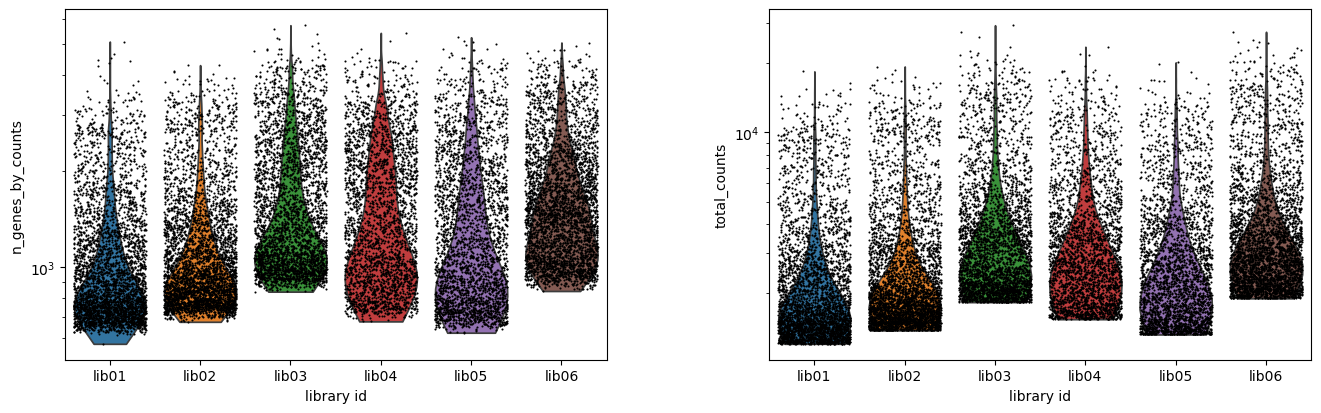

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], 
             groupby='library_id', size=1.5, log=True, jitter=0.4, multi_panel=True)

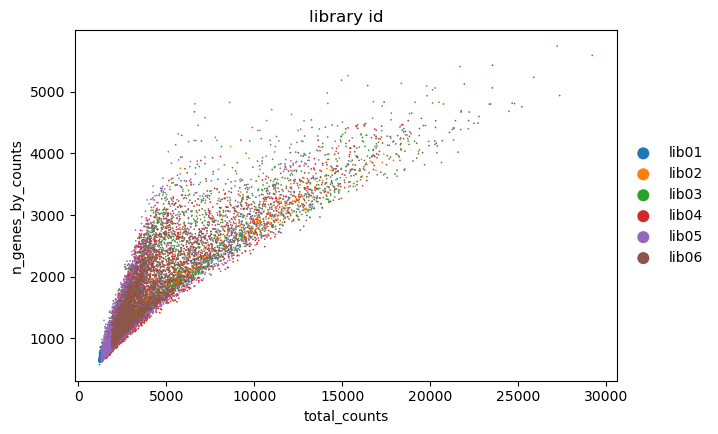

In [11]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='library_id')


In [12]:
summary = adata.obs.groupby("library_id")[["n_genes_by_counts", "total_counts"]].describe()
summary

/tmp/ipykernel_1111511/4100402543.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = adata.obs.groupby("library_id")[["n_genes_by_counts", "total_counts"]].describe()


n_genes_by_counts                                                   \
                       count         mean         std    min      25%     50%   
library_id                                                                      
lib01                 3627.0  1116.878963  587.502216  575.0   733.00   883.0   
lib02                 3941.0  1215.068511  621.909463  674.0   808.00   969.0   
lib03                 3352.0  1705.499403  865.767032  838.0  1038.75  1353.0   
lib04                 2723.0  1653.954829  848.037728  676.0   947.00  1385.0   
lib05                 2900.0  1479.984828  853.837128  623.0   813.00  1163.0   
lib06                 3629.0  1727.015156  772.698733  842.0  1129.00  1505.0   

                            total_counts                                    \
                75%     max        count         mean          std     min   
library_id                                                                   
lib01       1264.00  5098.0       3627.0  2604.276367  2212.307861  1207.0   
lib02       1356.00  4301.0       3941.0  2939.606445  2532.682373  1380.0   
lib03       2163.25  5738.0       3352.0  4219.347656  3480.601562  1831.0   
lib04       2188.50  5428.0       2723.0  3894.038086  3011.547119  1544.0   
lib05       1892.25  5258.0       2900.0  3276.505127  2641.374268  1325.0   
lib06       2087.00  5061.0       3629.0  4337.259766  3522.356201  1902.0   

                                              
                25%     50%     75%      max  
library_id                                    
lib01       1397.00  1710.0  2691.5  18402.0  
lib02       1588.00  1924.0  3011.0  19321.0  
lib03       2150.75  2925.0  4510.0  29197.0  
lib04       1952.00  2786.0  4412.5  23528.0  
lib05       1604.00  2285.0  3751.5  20129.0  
lib06       2309.00  3012.0  4596.0  27343.0

Text(0.5, 1.0, 'Gene counts per cell')

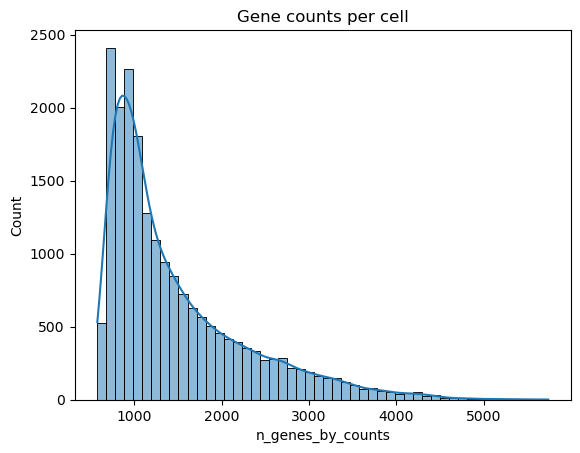

In [13]:
sns.histplot(data=adata.obs, x="n_genes_by_counts", bins=50, kde=True)
plt.title("Gene counts per cell")

Text(0.5, 1.0, 'Total counts per cell')

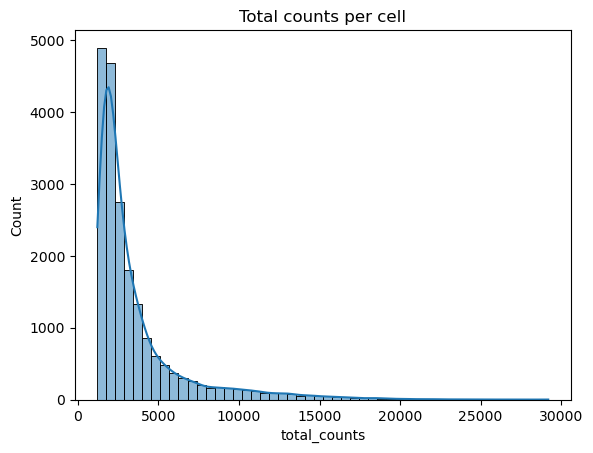

In [14]:
sns.histplot(data=adata.obs, x="total_counts", bins=50, kde=True)
plt.title("Total counts per cell")

## Preprocessing
pending: mt and ribo genes. Since they are not identified yet, we can not filter out damaged cells...
pending: use soup in R, reticulate python, in order to remove doublets in a better way

In [ ]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

In [ ]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20], log1p=True
)
adata

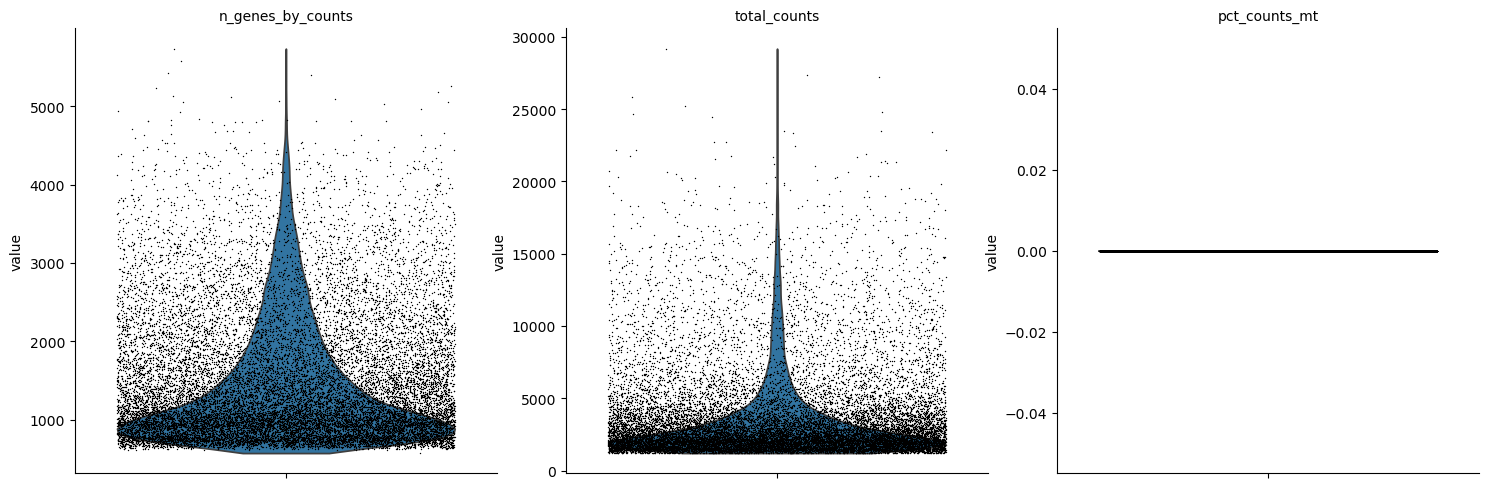

In [15]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# Calculate QC metrics
adata.var["mt"] = adata.var_names.str.startswith("mito_")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
# Plot QC
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)

## Filtering based on QC

In [16]:
# Apply thresholds based on inspection
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
# adata = adata[adata.obs.pct_counts_mt < 10, :] # mitocrondrial genes are not annotated in the var gene names
adata

View of AnnData object with n_obs × n_vars = 20172 × 29320
    obs: 'library_id', 'Count', 'Sample Name', 'Stage', 'Phenotype', 'Library ID', 'batch', 'n_counts', 'log_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log_genes', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt'
    uns: 'library_id_colors'

## Normalization and Log Transformation

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Highly Variable Genes

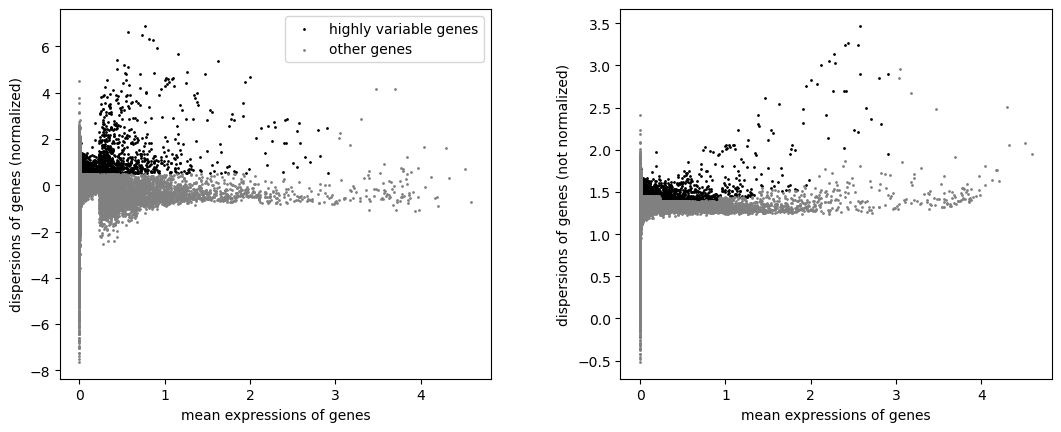

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

## PCA, Neighbors, UMAP
Initially we start without batch correction (data integration between batches)

/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


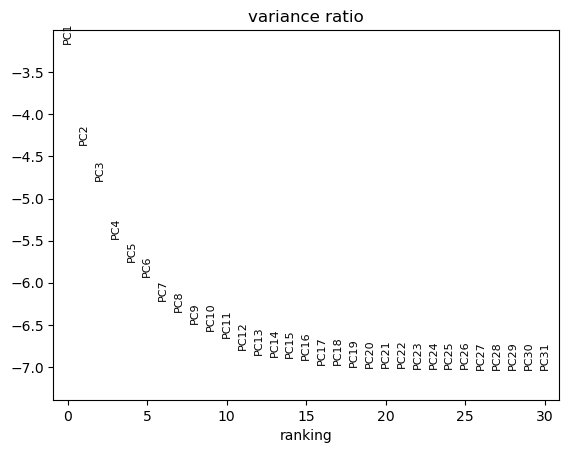

/home/msendra/miniforge3/envs/scRNAseq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


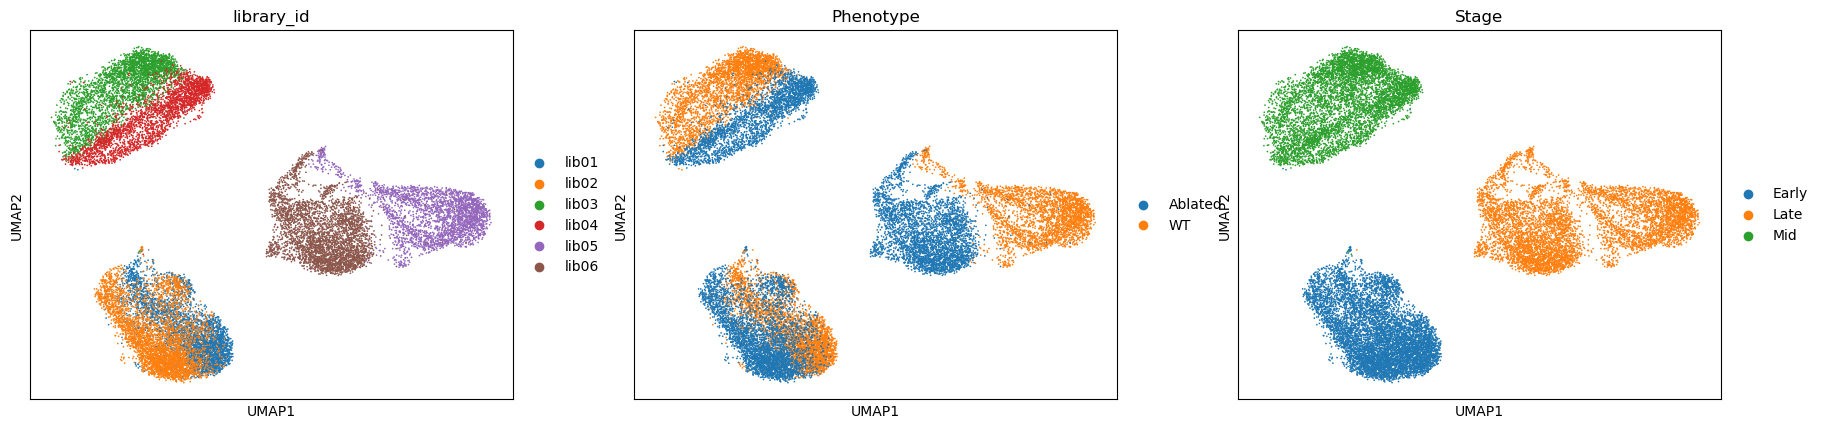

In [19]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['library_id', 'Phenotype', 'Stage'])

## Data integration (batch correction)
Following best practices in scRNAseq
https://www.sc-best-practices.org/cellular_structure/integration.html

Data integration methods work in these steps:
1. Dimensionality reduction.
2. Modeling and removing the batch effect.
3. Projection back into a high-dimensional space.


Batch-effect removal methods can vary in each of these three steps. They may use various linear or non-linear dimensionality reduction approaches, linear or non-linear batch effect models, and they may output different formats of batch-corrected data. Overall, we can divide methods for batch effect removal into 4 categories. In their order of development, these are global models, linear embedding models, graph-based methods, and deep learning approaches.

We will try this three libraries: Harmony, bbknn and scVI.


### Graph-based method: BBKNN (Batch Balanced KNN)
Graph-based method

⚠️ BBKNN modifies the neighborhood graph — do not re-run sc.pp.neighbors() after it.

In [20]:
import scanpy.external as sce

sce.pp.bbknn(adata, batch_key='library_id')
sc.tl.umap(adata)

consider updating your call to make use of `computation`


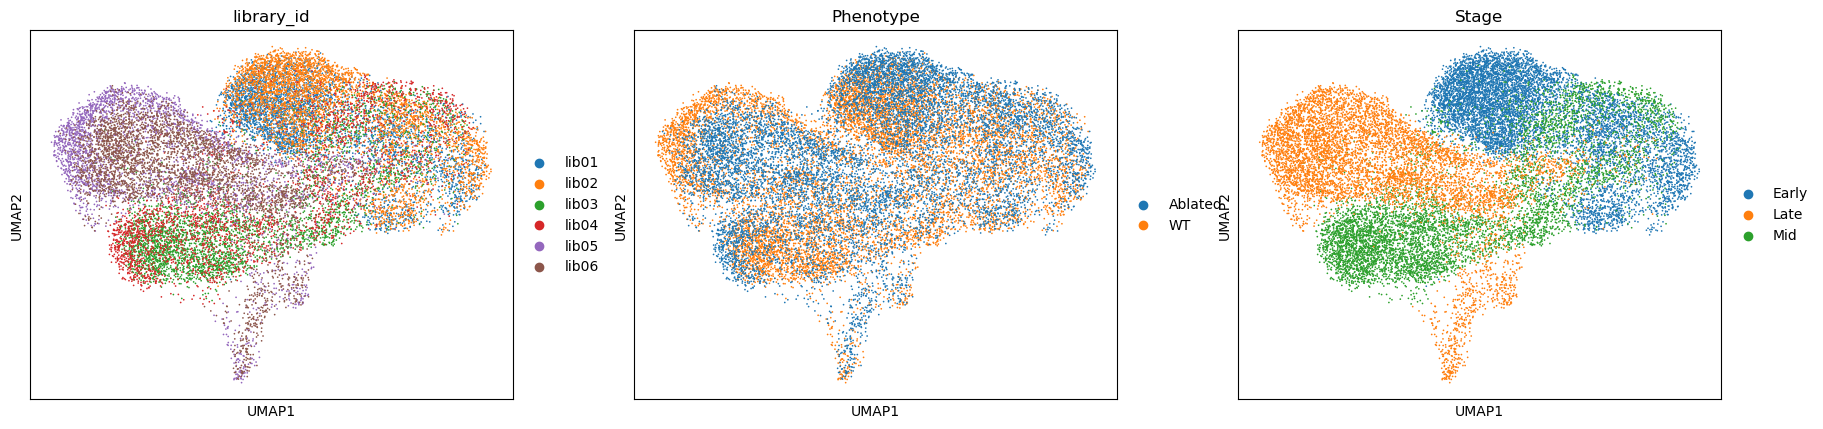

In [21]:
sc.pl.umap(adata, color=["library_id", "Phenotype", "Stage"])

In [22]:
# Save the AnnData object with BBKNN neighbors before applying other batch correction methods
adata_bbknn = adata.copy()
adata_bbknn.write(PROC_DATA_DIR / "adata_bbknn.h5ad")

### Deep learning method: scVI (Single-cell Variational Inference)
Pending, currently I am on the CPU workstation and I don't want to switch

## Pending: Add gene symbols to var_names
Using the files Tassos sent me from Averof lab, we can add gene symbols to the var_names of the AnnData object directly.
I will also try in paralel with the list John sent me with the gene symbols obtained from blasting to Uniprot.

## Clustering

/tmp/ipykernel_1111511/4062816493.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


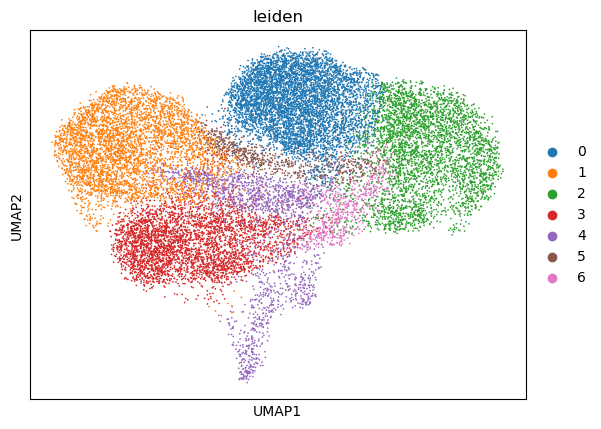

In [23]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])

## Marker Gene Identification

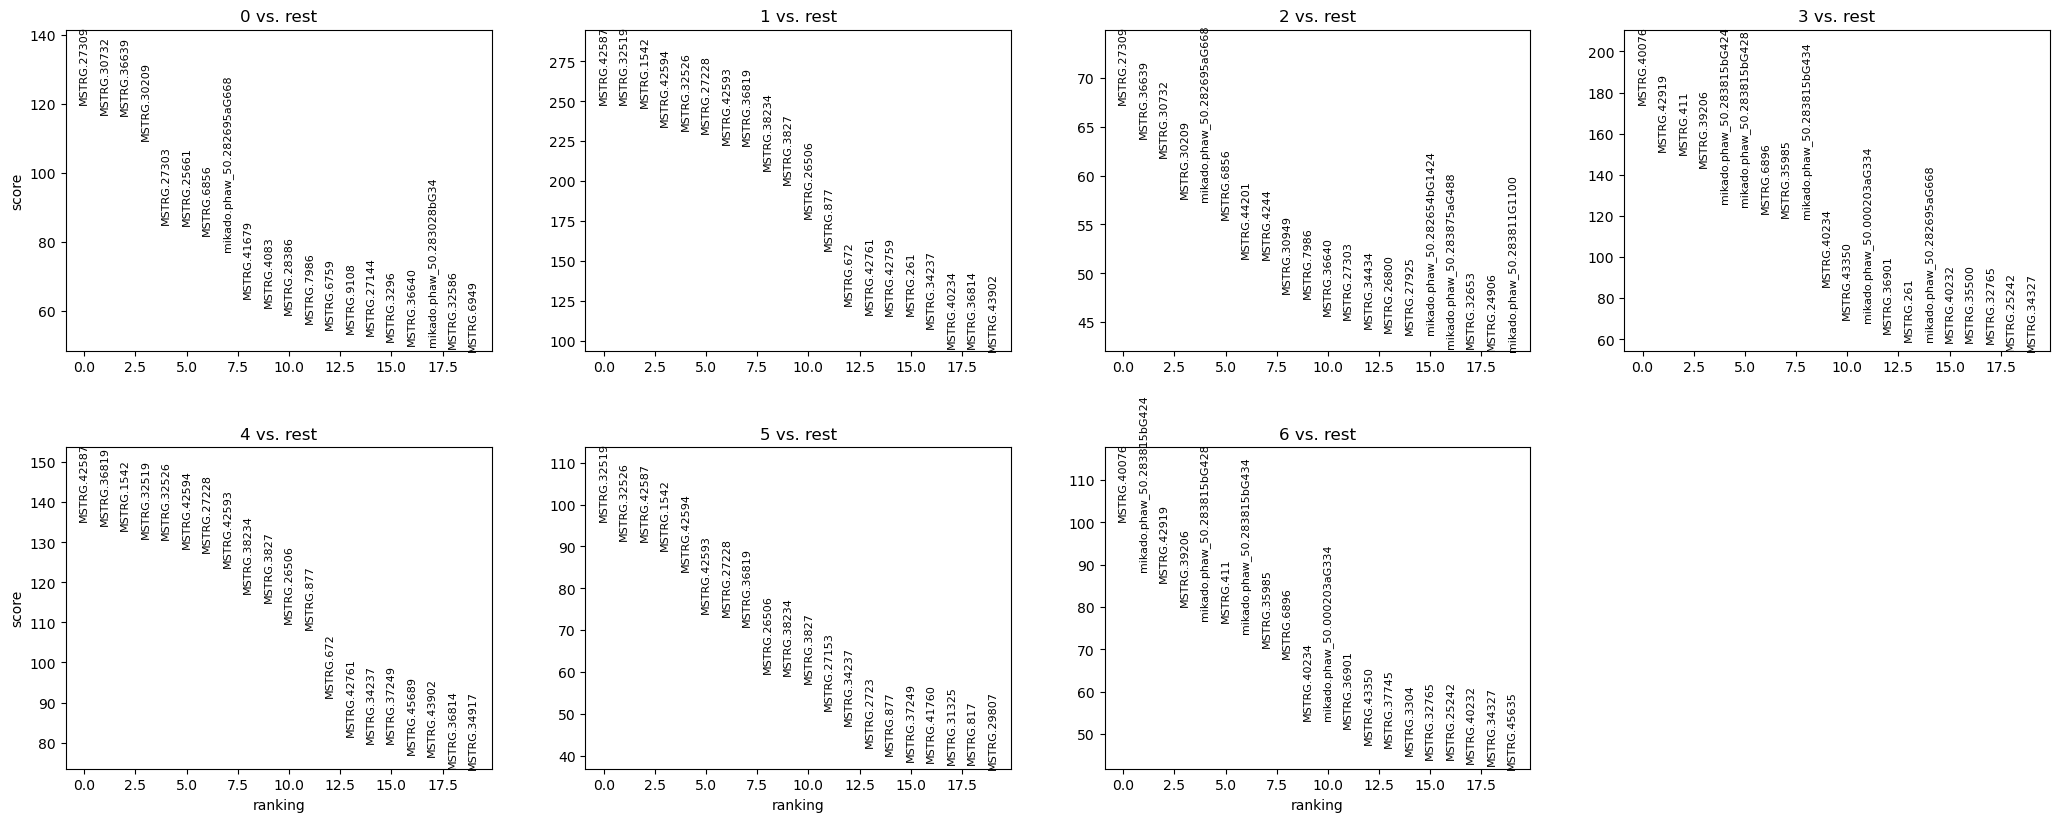

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## Save Processed Data

In [25]:
adata.write(PROC_DATA_DIR / "adata.h5ad")

In [52]:
adata.var_names

Index(['mikado.phaw_50.000059G4', 'mikado.phaw_50.000059G8', 'MSTRG.21',
       'MSTRG.36', 'MSTRG.42', 'MSTRG.53', 'MSTRG.61', 'MSTRG.82', 'MSTRG.88',
       'MSTRG.98',
       ...
       'MSTRG.45703', 'MSTRG.45706', 'MSTRG.45725', 'MSTRG.45733',
       'mikado.phaw_50.283875aG1352', 'MSTRG.45734', 'MSTRG.45753',
       'MSTRG.45758', 'MSTRG.45761', 'MSTRG.45770'],
      dtype='object', length=2138)

Parhyale still lacks well-curated genome annotations in major repositories...
HOW DO I DO TO IDENTIFY THE GENE SYMBOLS; NAMES???

homology mapping of drosophila¿¿?? or is there another better annotation. I see there is Damien_gene_models.gff3 in the folder but that seems to be older and does not contain gene names either. 

## PENDING NEXT STEP: ADD PSEUDOTIME, PAGA, ETC
Keep in mind they are not fully differentiated cells

90% cells should be ectoderm